In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from darksirens.cosmology.cosmo import Cosmology
from darksirens.mock_maker import *

from scipy.stats import norm

import random as r

r.seed(42) #Investigate how this affects everything

cosmopars = {'Omega_m': 0.32,
             'H0': 67.}


ABHpars = {'ABHmass': 7,
           'z_m': 2.,
           'a': 2.37,
           'b': 1.8}

PBHpars = {'PBHmass': 10,
           'clustering': 'no',
           'fPBH': 1.e-5}

#Survey specifications
specs = {'survey': 'ET-D',
         'z_min': 0.001,
         'z_max': 100,
         'Tobs': 1,
         'SNR_min': 8,
         'include_lensing': False}

progenitor = 'mixed'

zdist  = np.linspace(0.01,50,1000)

clight = 299792.458

## LIGO bound


**WARNING:** careful with self.Tligo = 0.5*self.year in class event_number_calculator 

In [2]:
cosmo = Cosmology(cosmopars)

M_PBH_vec_2 = np.array([7.,15.,25.,35.])
M_PBH_err_2 = np.array([3.,5.,5.,5.])
#
M_PBH_vec_3 = np.array([12.5, 35., 75.])
M_PBH_err_3 = np.array([7.5, 15., 25.])
#
f_PBH_vec = np.logspace(-5,0,200)

def MRLigo_GWTC2(M_): # Using Table 4 in https://arxiv.org/abs/2010.14533
    
    rate = 0.
    error = 0.  
    
    if ((M_ >= 4.) and (M_ < 10.)):
        rate = 7.86
        error = 11.17
    elif ((M_ >= 10.) and (M_ < 20.)):
        rate = 8.89
        error = 5.29
    elif ((M_ >= 20.) and (M_ < 30.)):
        rate = 3.71
        error = 1.58
    elif ((M_ >= 30.) and (M_ < 40.)):
        rate = 2.04
        error = 1.16
    return rate, error

def MRLigo_GWTC3(M_): # Using Table 4 in https://arxiv.org/abs/2111.03634
    
    rate = 0.
    error = 0. #quoted at the 90% credible interval
    
    if ((M_ >= 5.) and (M_ < 20.)):
        rate = 23.4
        error = 12.9
    elif ((M_ >= 20.) and (M_ < 50.)):
        rate = 4.5
        error = 1.8
    elif ((M_ >= 50.) and (M_ < 100.)):
        rate = 0.2
        error = 0.1
    return rate, error


def computeBound(M_PBH_, MRLigoFunc, verbose="True", considerClustering="no"):
    
    if (verbose):
        print("M = ", M_PBH_)
    rateGWTC2, errorGWTC2 = MRLigoFunc(M_PBH_)
    RligoGWTC2_2sigma = rateGWTC2 + errorGWTC2    
    PBHeventsLIGO_ = 0.
    result = 1.
    
    if (M_PBH_ >=5):
        for iF, f_PBH_ in enumerate(f_PBH_vec):

            PBHpars_ = {'PBHmass': M_PBH_,
               'clustering': considerClustering,
               'fPBH': f_PBH_}
            EventCalculator = event_number_calculator(cosmo,ABHpars,PBHpars_,specs)
            PBHeventsLIGO_ = EventCalculator.MRligoPBH_calculator(PBHpars_, cosmo)
            if (PBHeventsLIGO_ > RligoGWTC2_2sigma):
                break
                
        if (verbose):
            print("I am setting the upper limit at f = ", f_PBH_vec[iF], " where the rate is ", PBHeventsLIGO_) 
        result = f_PBH_vec[iF]
    
    return result

In [3]:
"*** GWTC2 Bound ***"    
bound_GWTC2 = np.asarray([computeBound(M_PBH_, MRLigo_GWTC2) for M_PBH_ in M_PBH_vec_2])
#bound_GWTC2_clustering = np.asarray([computeBound(M_PBH_, MRLigo_GWTC2, considerClustering="yes") for M_PBH_ in M_PBH_vec_2])
"*** GWTC3 Bound ***" 
bound_GWTC3 = np.asarray([computeBound(M_PBH_, MRLigo_GWTC3) for M_PBH_ in M_PBH_vec_3])
#bound_GWTC3_clustering = np.asarray([computeBound(M_PBH_, MRLigo_GWTC3, considerClustering="yes") for M_PBH_ in M_PBH_vec_3])

M =  7.0
I am setting the upper limit at f =  0.0009658832241158709  where the rate is  21.064479533743157
M =  15.0
I am setting the upper limit at f =  0.0010843659686896108  where the rate is  15.100972039271324
M =  25.0
I am setting the upper limit at f =  0.0007663410868007462  where the rate is  5.40716294757647
M =  35.0
I am setting the upper limit at f =  0.0006826071834272392  where the rate is  3.4975926529990025
M =  12.5
I am setting the upper limit at f =  0.0016257556664437951  where the rate is  38.303120305433225
M =  35.0
I am setting the upper limit at f =  0.0009658832241158709  where the rate is  6.980144444221674
M =  75.0
I am setting the upper limit at f =  0.0002704959730463137  where the rate is  0.3318154461525377


[0.00096588 0.00108437 0.00076634 0.00068261]
[0.00162576 0.00096588 0.0002705 ]


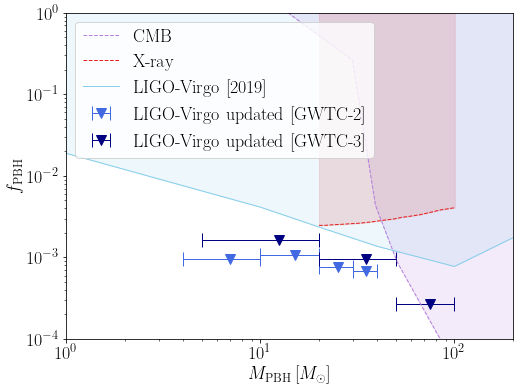

In [4]:
import matplotlib
from matplotlib.pyplot import figure
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

print(bound_GWTC2)
#print(bound_GWTC2_clustering)
print(bound_GWTC3)
#print(bound_GWTC2_clustering)

#credit: https://github.com/bradkav/PBHbounds/blob/master/PlotPBHbounds.py
def addConstraintEdited(boundID, col='blue',x = 1e-30,y=1e-4,ang=0, linestyle='-', label="temp"):
    m, f = np.loadtxt('bounds/' + boundID + '.txt', unpack=True)
    plt.fill_between(m , np.clip(f, 0,1), 1, alpha=alpha_val, color=col)
    linewidth = 1.0
    plt.plot(m, np.clip(f, 0,1), color=col, lw=linewidth, linestyle=linestyle, label=label)

plt.figure(figsize=(8,6))

#plt.plot(M_PBH_vec, bound_GWTC2, color="red", 'v', label="LIGO bound [GWTC-2 2010.14533]")
plt.errorbar(M_PBH_vec_2, bound_GWTC2, yerr=None, xerr=M_PBH_err_2,  fmt = 'v',color = 'RoyalBlue', ecolor = 'RoyalBlue', elinewidth = 1., capsize=7, markersize=10., label="LIGO-Virgo updated [GWTC-2]")
#plt.fill_between(M_PBH_vec_2 , np.clip(bound_GWTC2, 0,1), 1, alpha=alpha_val, color="RoyalBlue")
#plt.errorbar(M_PBH_vec_2, bound_GWTC2_clustering, yerr=None, xerr=M_PBH_err_2,  fmt = 'v',color = 'maroon', ecolor = 'maroon', elinewidth = 1., capsize=7, markersize=10., label="LIGO bound [GWTC-2, clustered model]")
plt.errorbar(M_PBH_vec_3, bound_GWTC3, yerr=None, xerr=M_PBH_err_3,  fmt = 'v',color = '#000080', ecolor = '#000080', elinewidth = 1., capsize=7, markersize=10., label="LIGO-Virgo updated [GWTC-3]")
#plt.fill_between(M_PBH_vec_3 , np.clip(bound_GWTC3, 0,1), 1, alpha=alpha_val, color="#000080")
#plt.errorbar(M_PBH_vec_3, bound_GWTC3_clustering, yerr=None, xerr=M_PBH_err_3,  fmt = 'v',color = 'navy', ecolor = 'navy', elinewidth = 1., capsize=7, markersize=10., label="LIGO bound [GWTC-3, clustered model]")

# Other bounds
alpha_val = 0.15
addConstraintEdited("CMB", col='#B57EDC',linestyle='--', label="CMB")
#addConstraintEdited("EROS", col='#FFA343',linestyle='--', label="EROS")
addConstraintEdited("X-ray", col='#E62020',linestyle='--', label="X-ray")
addConstraintEdited("LIGO2019", col='#87CEEB',linestyle='-', label="LIGO-Virgo [2019]")

plt.xlim(1.,200.)
plt.ylim(1e-4,1.)

plt.xlabel(r'$M_{\rm PBH}\/\left[M_\odot\right]$')
plt.ylabel(r'$f_{\rm PBH}$')
plt.xscale("log")
plt.yscale("log")

plt.legend(loc="upper left")
plt.savefig('LIGObound.pdf', dpi=300)
plt.show()              